In [71]:
import os 
import torch
import torchvision
import tarfile
import zipfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as T

from torch.utils.data import random_split
from torchvision.utils import make_grid

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

# I. Data preparation:
1. Download and Transform data to tensor:
    * Data augmentation: Crop image to 200x200 pixels, with padding, and add horizontal Flip
2. Put data in batches of 5 and onto cpu

In [72]:
#Download dataset
data_url="https://github.com/paras42/Hello_World_Deep_Learning/blob/9921a12c905c00a88898121d5dc538e3b524e520/Open_I_abd_vs_CXRs.zip"
#Download data set and put into current folder by indication '.'
download_url(data_url,'.')

Using downloaded and verified file: ./Open_I_abd_vs_CXRs.zip


In [73]:
#Extract file from archive
#Open zipfile, open in readmode as zip by 'r'
with zipfile.ZipFile('Open_I_abd_vs_CXRs.zip','r') as myzip:
    #Given tar object extract info and put to target folder data
    myzip.extractall(path='./data')

In [74]:
#Look at data set in folder data
data_dir='./data/Open_I_abd_vs_CXRs'

print(os.listdir(data_dir))
classes = os.listdir(data_dir+'/TRAIN') #Go into train folder
print(classes) #See all classes folder available in train data

#We can go into these classes folder
abd_file=os.listdir(data_dir+'/TRAIN/openI_abd_xray')
print('No. of training pts of abd xray: ', len(abd_file))
print('Some content of abd train file: ', abd_file[:2])

['TEST', 'TRAIN', 'VAL']
['openI_CXR', 'openI_abd_xray']
No. of training pts of abd xray:  32
Some content of abd train file:  ['PMC3913410_umj0082-0179-f4.png', 'openI_19.png']


In [75]:
#Compose is used to combined augmentation techniques, we list here first
img_size = 299
stat = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
preprocess = T.Compose([
    T.Resize(299),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

#train_tfsm = T.Compose([T.Resize(img_size),T.RandomCrop(299, padding =4, padding_mode='reflect'),T.RandomHorizontalFlip(),T.ToTensor()])
train_ds = ImageFolder(data_dir+'/TRAIN',transform = preprocess)
#We dont perform augmentation on validation set
val_ds = ImageFolder(data_dir+'/VAL',transform = preprocess)

In [76]:
# Put data in batches
batch_size = 5
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_dl = DataLoader(val_ds,batch_size,num_workers=4,pin_memory=True)

In [77]:
#Denormalize to plot data
def denormalize(img,means,stds):
    means = torch.tensor(means).reshape(1,3,1,1) #To get seperate mean for 3 channels of 1 batch
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return img*stds+means

# Plot some data for visualization
def show_batch(dl):
    for images,labels in dl:
        fig,ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]); ax.set_yticks([])
        print('Image shape is: ',images.shape)
        print('Image label is: ',labels)
        ax.imshow(make_grid(denormalize(images,*stat)[:200], nrow=5).permute(1, 2, 0).clamp(0,1))
        break

Image shape is:  torch.Size([5, 3, 299, 299])
Image label is:  tensor([1, 0, 0, 1, 0])


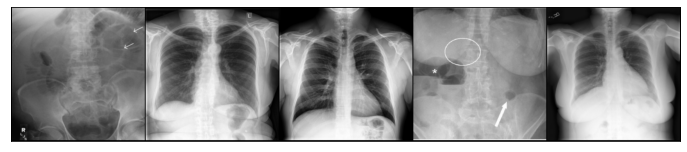

In [78]:
show_batch(train_dl)

In [79]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [80]:
#Get device
device = get_default_device()
print(device)

#Move data onto GPU
train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(val_dl, device)

cpu


# II. Design model and Train:
1. Use Transfer learning: base model employed is Inception V3, with prerained weights from ImageNet. Remove also top Fully Connected Layer and replace with CNN 

In [88]:
#Part 1: basic functionality, base is nn.Module
class ImageClassificationBase(nn.Module): 
    
    def training_step(self,batch):
        images,labels = batch
        labels = labels.to(torch.float32)
        out=self(images) #By nn.module, self invoke forward here to gen pred
        loss=F.binary_cross_entropy(out,labels) #Calculate loss
        return loss
    
    def accuracy(self,result,labels):
        preds = result > 0.5
        return torch.tensor(torch.sum(preds==labels).item()/len(preds))
    
    def validation_step(self,batch):
        images,labels = batch
        out = self(images) #now that param is updated
        labels = labels.to(torch.float32)
        loss = F.binary_cross_entropy(out,labels) # Cal loss
        acc = self.accuracy(out,labels) #Cal accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self,outputs): # over all data pts     
        batch_losses = [x['val_loss'] for x in outputs]
        #stack bring [tensor(1),tensor(2)]->tensor([1,2])
        epoch_loss = torch.stack(batch_losses).mean()  #Combine loss
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean() #Combine acc
        #item for get rid of tensor -> number
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self,epoch,result):
        print('Epoch[{}], train_loss: {:.4f},val_loss:{:.4f}, val_acc: {:.4f}'.format(epoch,result['train_loss'],
                                                                    result['val_loss'],
                                                                    result['val_acc']))

In [89]:
#Replace the top layer with a block consist of Average pooling and Fully Connected
def top_block(fc_in,num_classes):
    layers = [nn.Linear(fc_in,256),
             nn.ReLU(inplace=True),
             nn.Dropout(0.5),
             nn.Linear(256,num_classes),
             nn.Sigmoid()]

    return nn.Sequential(*layers)

class XRayModel(ImageClassificationBase):
    def __init__(self,num_classes,pretrained=True):
        super().__init__()
        
        #Use pretrain inception V3 with weights from imagenet
        self.network = models.inception_v3(pretrained=pretrained, aux_logits=False)
        
        #Add ontop the model defined above, with input size being the one fed into original 
        #FC layer of IV3
        self.network.fc=top_block(self.network.fc.in_features,
                                  num_classes)
    def forward(self,xb):
        out= self.network(xb)
        return out.squeeze()

In [90]:
model = to_device(XRayModel(1,pretrained=True),device)

In [91]:
def fit(epochs, lr, model, train_loader, val_loader, 
        opt_funct= torch.optim.SGD):
    
    #Define optimizer
    optimizer = opt_funct(model.parameters(), lr=lr, betas=(0.9, 0.999),
                            eps=1e-08, weight_decay=0)
    history =[] #for recording epoch-wise results
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        #Training phase
        for batch in tqdm(train_loader):
            loss = model.training_step(batch) #Foward pass + loss cal
            train_losses.append(loss)
            loss.backward()
            optimizer.step() #update parameters
            optimizer.zero_grad() #Set gradient back to zero
        
        #Validation phase: Once training is done for all batch of train   
        res = evaluate(model,val_loader) #here model is loaded with new param
        res['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch,res) # print avarage loss and/or accuracy
        history.append(res) #append val result for this iteration
        
    return history

@torch.no_grad()
def evaluate(model,val_loader):
    model.eval() 
    outputs = [model.validation_step(batch) for batch in val_loader]
    #print(outputs)
    return model.validation_epoch_end(outputs)

In [92]:
#Train Model
epochs = 20
lr=0.0001
opt_funct= torch.optim.Adam

In [93]:
train_res = fit(epochs, lr, model, train_loader, val_loader, opt_funct)


Epoch[0], train_loss: 0.6067,val_loss:0.4389, val_acc: 0.8000



Epoch[1], train_loss: 0.3889,val_loss:0.2223, val_acc: 1.0000



Epoch[2], train_loss: 0.2126,val_loss:0.0969, val_acc: 1.0000



Epoch[3], train_loss: 0.0852,val_loss:0.0385, val_acc: 1.0000



Epoch[4], train_loss: 0.1346,val_loss:0.0228, val_acc: 1.0000



Epoch[5], train_loss: 0.0780,val_loss:0.0168, val_acc: 1.0000



Epoch[6], train_loss: 0.0407,val_loss:0.0119, val_acc: 1.0000



Epoch[7], train_loss: 0.0758,val_loss:0.0255, val_acc: 1.0000



Epoch[8], train_loss: 0.0262,val_loss:0.0156, val_acc: 1.0000



Epoch[9], train_loss: 0.0233,val_loss:0.0059, val_acc: 1.0000



Epoch[10], train_loss: 0.2456,val_loss:0.0062, val_acc: 1.0000



Epoch[11], train_loss: 0.0900,val_loss:0.0090, val_acc: 1.0000



Epoch[12], train_loss: 0.0577,val_loss:0.0113, val_acc: 1.0000



Epoch[13], train_loss: 0.0543,val_loss:0.0106, val_acc: 1.0000



Epoch[14], train_loss: 0.2559,val_loss:0.0063, val_acc: 1.0000



Epoch[15], train_loss: 0.0650,val_loss:0.0024, val_acc: 1.0000



Epoch[16], train_loss: 0.0154,val_loss:0.0041, val_acc: 1.0000



Epoch[17], train_loss: 0.1877,val_loss:0.0252, val_acc: 1.0000



Epoch[18], train_loss: 0.1038,val_loss:0.0069, val_acc: 1.0000



Epoch[19], train_loss: 0.0591,val_loss:0.0067, val_acc: 1.0000


In [94]:
torch.save(model.state_dict(),'Chest_Abd_Xray.pth')

Image shape is:  torch.Size([2, 3, 299, 299])
Image label is:  tensor([0, 1])
{'val_loss': 0.003928676247596741, 'val_acc': 1.0}


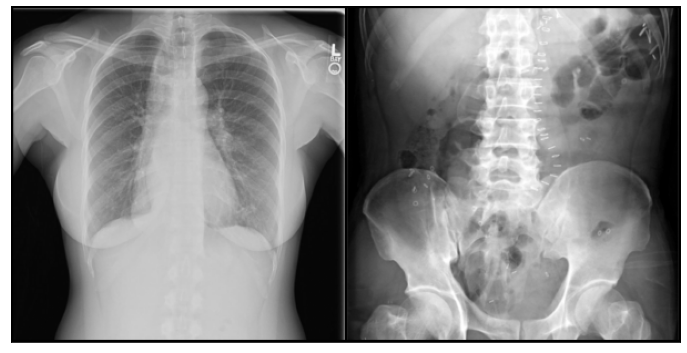

In [95]:
#Evaluate on testset
test_set = ImageFolder(data_dir +'/TEST',transform=preprocess)
test_loader = DeviceDataLoader(DataLoader(test_set,batch_size), device)
show_batch(test_loader)
test_res=evaluate(model,test_loader)
print(test_res)

In [96]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

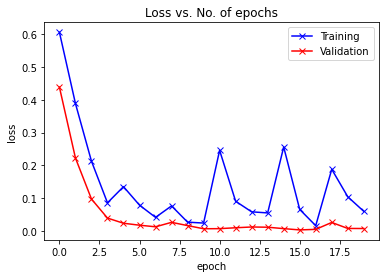

In [97]:
plot_losses(train_res)